# Gesture Recognition
- In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.</br>

# Functions, Flasses and Activities
---
>generator(): &nbsp;&nbsp;&nbsp;&nbsp; yield batch of images normalize</br>
get_step(): &nbsp;&nbsp;&nbsp;&nbsp; Create steps_per_epochs and validation_steps</br>
Gesture_Module: &nbsp;&nbsp;&nbsp;&nbsp; Contain all Models</br>
plot_accuracy(): &nbsp;&nbsp;&nbsp;&nbsp; Visualize values of Accuracy training</br>
plot_loss(): &nbsp;&nbsp;&nbsp;&nbsp; Visualize values of Loss</br>
save_model_path(): &nbsp;&nbsp;&nbsp;&nbsp; Create path to save models</br>
callback_lists(): &nbsp;&nbsp;&nbsp;&nbsp; Create callback for Models
---

## Import the Libraries

In [1]:
import numpy as np
import os
import datetime
import os
import random as rn
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from imageio import imread
from skimage.transform import resize

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Flatten,RepeatVector, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

tf.__version__

'2.9.0'

In [2]:
np.random.seed(30)
rn.seed(30)
tf.keras.utils.set_random_seed(30)

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

batch_size = 16
num_epochs = 30
image_width = 128
image_height = 128
target_size = (image_width, image_height, 3)

- Create default "steps per epochs" and "validation steps"

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

def get_step(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

steps_per_epoch, validation_steps = get_step(num_train_sequences, num_val_sequences, batch_size)
    
print('# Step per Epochs = ',steps_per_epoch)
print('# Validation steps = ', validation_steps)

# Training sequences = 663
# Validation sequences = 100
# epochs = 30
# Step per Epochs =  42
# Validation steps =  7


In [5]:
# Create sequence leng
img_idx = list(range(0,30))
x=len(img_idx)
            
    
def generator(source_path, folder_list, batch_size, target_size, normalize_type=0):
    '''
        The function yield each of data with shape [batch_size, sequence_len, shape_x, shape_y, channel]
        source_path: str
        folder_list: list, total folders containing videos
        batch_size: int
        target_size: tuple(height, width, channel)
        normalize_type: --->    '0':  divide pixel value by 255 (default)
                                '1':  scale zero center (img-127)/127.
                                '2':  scale distribution percentile
                                '3':  pretrain with vgg processing_input
                           ------------------ ********** -------------------
        
    '''
    print( ' Source path = ', source_path, '; Batch size =', batch_size, '; Target size =', target_size, '; Normalize_type =', normalize_type)
    y, z, _ = target_size
    while True:
        shuf = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        path_inter = 0
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[0] != image.shape[1]:
                        image = image[0:120, 20:140]
                    image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    if normalize_type == 1:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    elif normalize_type == 2:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] -np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,1] = image[:,:,1] -np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,2] = image[:,:,2] -np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) -np.percentile(image[:,:,0],5))
                    elif normalize_type == 3:
                        image = tf.keras.applications.vgg16.preprocess_input(image, data_format=None)
                        batch_data[folder,idx,:,:,:] = image
                    else:
                        batch_data[folder,idx,:,:,:] = image/255.
                    
                batch_labels[folder, int(shuf[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            path_inter = batch
            yield batch_data, batch_labels        
        
        folders_not_process = len(folder_list)-num_batches*batch_size
        if folders_not_process !=0:   # Process the Residual after appling batch_size : E.g total_video = 663, batch=16 . residual = 663-(663//16)*16 = 7
            path_inter+=1             # Continues at shuffle total_video[path_inter]. Created above
            batch_data = np.zeros((folders_not_process,x,y,z,3))
            batch_labels = np.zeros((folders_not_process,5))

            for folder in range(folders_not_process):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (path_inter*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (path_inter*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[0] != image.shape[1]:
                        image = image[0:120, 20:140]
                    image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    if normalize_type == 1:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    elif normalize_type == 2:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] -np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,1] = image[:,:,1] -np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,2] = image[:,:,2] -np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) -np.percentile(image[:,:,0],5))
                    elif normalize_type == 3:
                        image = tf.keras.applications.vgg16.preprocess_input(image, data_format=None)
                        batch_data[folder,idx,:,:,:] = image
                    else:
                        batch_data[folder,idx,:,:,:] = image/255.
                    
                batch_labels[folder, int(shuf[folder + (path_inter*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

## Model Definitions

## Build Class contains 3 Version of CNN3D model 

In [15]:
# Defined class contain all of model and pretrain model
# Convenient for calling model
class Gesture_Module:
    def __init__(self, input_shape, no_class):
        self.input_shape = input_shape
        self.no_class = no_class
        
    def cnn3d_v1(self):
        model = Sequential(name='cnn3D_lstm_01')

        model.add(Conv3D(8, (3,3,3), input_shape=self.input_shape, padding='same'))        
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        
        model.add(Conv3D(16, (3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        model.add(Flatten())
        
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

    
    def cnn3d_v2(self):
        model = Sequential(name='cnn3D_lstm_02')

        model.add(Conv3D(8, (3,3,3), input_shape=self.input_shape, padding='same'))        
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        
        model.add(Conv3D(8, (3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        model.add(Flatten())
        
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_class, activation='softmax'))
        return model
    
    def cnn3d_v3(self):
        model = Sequential(name='cnn3D_lstm_03')

        model.add(Conv3D(16, (3,3,3), input_shape=self.input_shape, padding='same'))        
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        model.add(Dropout(0.3))
        
        model.add(Conv3D(16, (3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        model.add(Dropout(0.3))
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D((2,2,2)))
        model.add(Dropout(0.3))
        model.add(Flatten())
        
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

## Plotting Functions
## Create Path Functions
## Create Callbacks Functions

In [7]:
# Function to plot the model accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Function to plot the model loss
def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# Model storage path constructor
def save_model_path(model_name):
    model_name = 'output/CNN3D/'+model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.makedirs(model_name)
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    return filepath

# initialize Callbacks function 
def callback_lists(filepath, monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=1e-5):
    print('# filepath: ', filepath)
    print('# min_lr: ', min_lr)
    print('# monitor: ', monitor)
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=False, mode=mode, period=1)
    LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,
                                             factor=factor,
                                             patience=patience,
                                             mode=mode,
                                             min_lr=min_lr)
    return  [checkpoint, LR]

In [20]:
# Number of classification classes
no_class = 5 # [Thumbs up, Thumbs down, Left swipe, Right swipe, secondsStop]
batch_size = 16
# Input shape (sequence_len, shapeY, shapeX, channel)
input_shape = (len(img_idx), image_height, image_width, 3)
# Instantiate the model class
GestureNet = Gesture_Module(input_shape, no_class)

## Buidl CNN3D Model version 1

In [9]:
model_cnn3d_v1  = GestureNet.cnn3d_v1()

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=1)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=1)

filepath = save_model_path(model_cnn3d_v1.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3,)
model_cnn3d_v1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnn3d_v1.summary())

# filepath:  output/CNN3D/cnn3D_lstm_01_2022-11-1617_54_41.219995/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn3D_lstm_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 128, 128, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 128, 128, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 8)    0         
 )                                                               
                                          

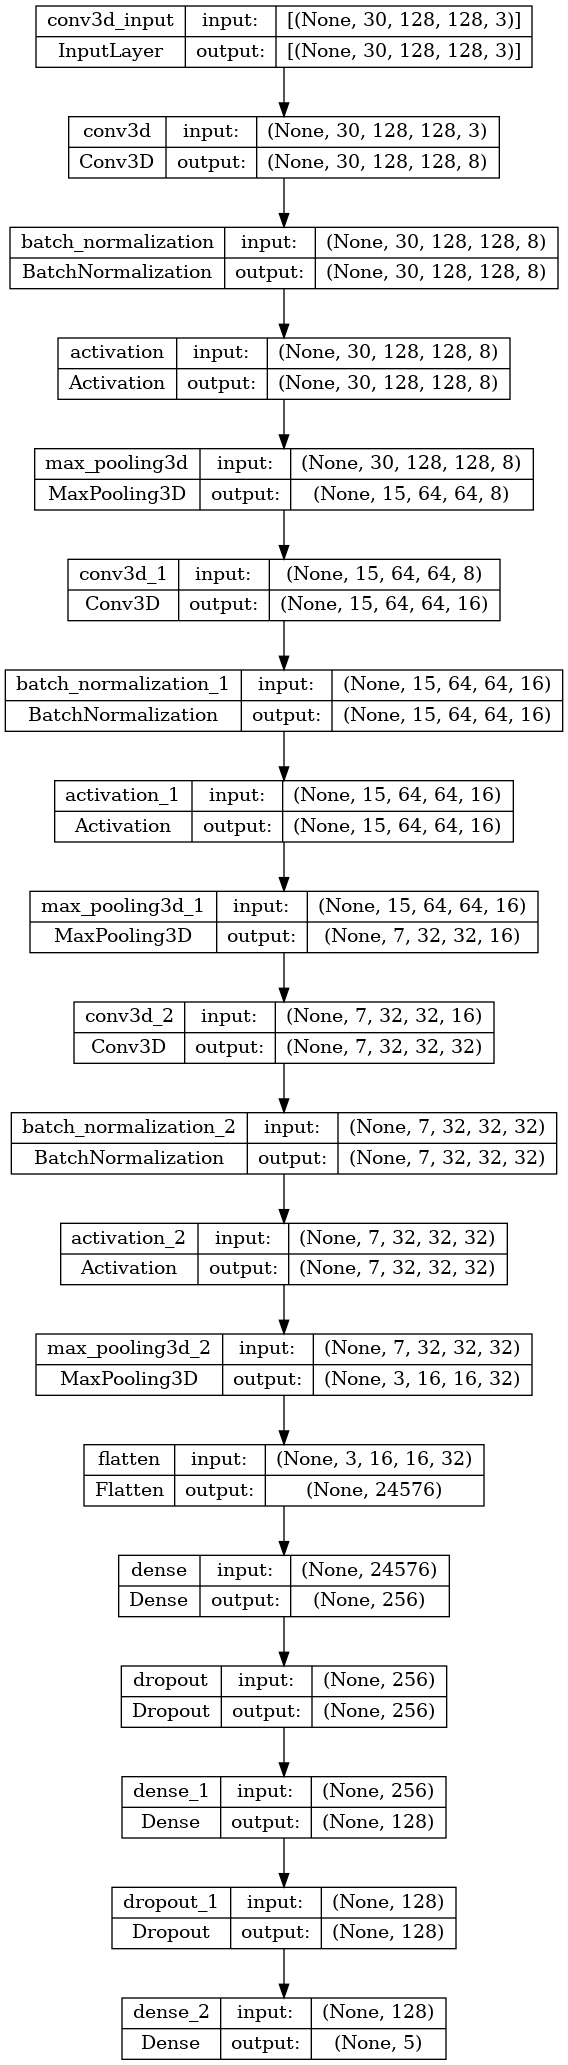

In [10]:
# Plot a diagram of the model
tf.keras.utils.plot_model(model_cnn3d_v1, "cnn3d_01.png", show_shapes=True)

In [11]:
#Train with Epochs=20
num_epochs=20
model_cnn3d_v1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1


<ipython-input-11-bbc7d4c60caa>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_cnn3d_v1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 11.3031 - categorical_accuracy: 0.2443 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1

Epoch 1: val_loss improved from inf to 2.06422, saving model to output/CNN3D/cnn3D_lstm_01_2022-11-1617_54_41.219995/model-00001-11.30306-0.24434-2.06422-0.23000.h5
42/42 [==============================] - 41s 937ms/step - loss: 11.3031 - categorical_accuracy: 0.2443 - val_loss: 2.0642 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.6530 - categorical_accuracy: 0.2262
Epoch 2: val_loss improved from 2.06422 to 1.55308, saving model to output/CNN3D/cnn3D_lstm_01_2022-11-1617_54_41.219995/model-00002-1.65296-0.22624-1.55308-0.28000.h5
42/42 [==============================] - 38s 933ms/step - loss: 1.6530 - categorical_accuracy: 0.2262 - val_loss: 1.5531 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
42

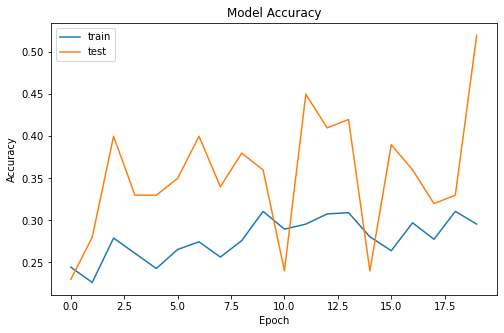

In [12]:
# Plot the model accuracy
plot_accuracy(model_cnn3d_v1.history)

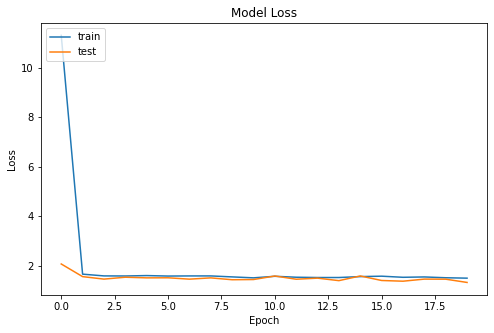

In [13]:
# Plot the model loss
plot_loss(model_cnn3d_v1.history)

## Buidl CNN3D Model version 2

In [21]:
model_cnn3d_v2  = GestureNet.cnn3d_v2()

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=2)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=2)

filepath = save_model_path(model_cnn3d_v2.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3,)
model_cnn3d_v2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnn3d_v2.summary())

# filepath:  output/CNN3D/cnn3D_lstm_02_2022-11-1617_54_41.219995/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn3D_lstm_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 30, 128, 128, 8)   656       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 128, 128, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 30, 128, 128, 8)   0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 15, 64, 64, 8)    0         
 3D)                                                             
                                          

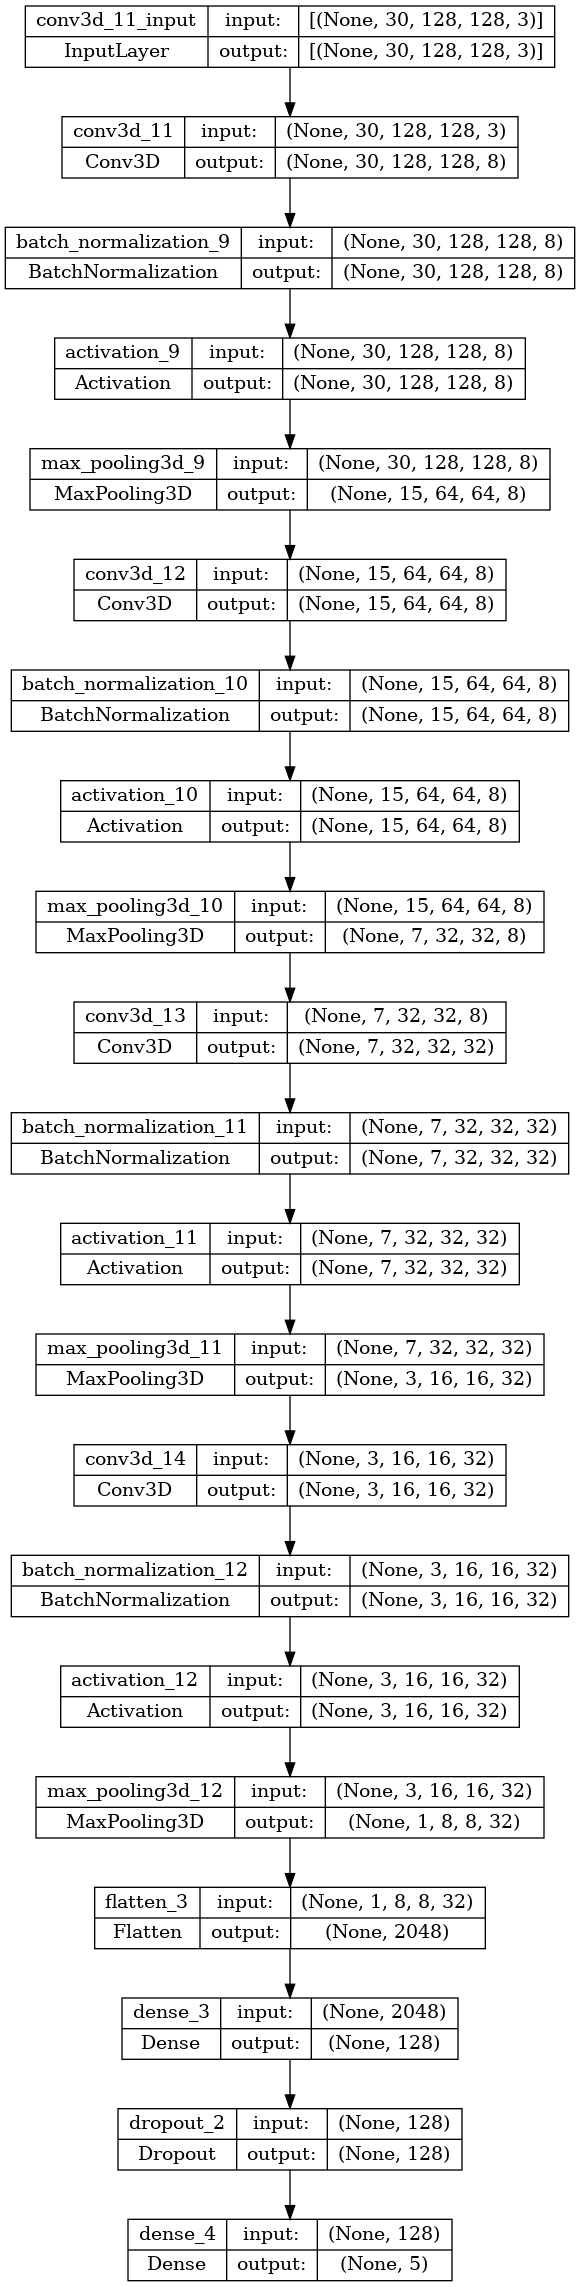

In [22]:
# Plot a diagram of the model
tf.keras.utils.plot_model(model_cnn3d_v2, "cnn3d_02.png", show_shapes=True)

In [23]:
#Train with Epochs=20
num_epochs=20
model_cnn3d_v2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-23-f870b152235b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_cnn3d_v2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 2
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.8780 - categorical_accuracy: 0.3348 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 2

Epoch 1: val_loss improved from inf to 6.33344, saving model to output/CNN3D/cnn3D_lstm_02_2022-11-1617_54_41.219995/model-00001-1.87799-0.33484-6.33344-0.23000.h5
42/42 [==============================] - 80s 2s/step - loss: 1.8780 - categorical_accuracy: 0.3348 - val_loss: 6.3334 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.1818 - categorical_accuracy: 0.4691
Epoch 2: val_loss improved from 6.33344 to 2.74245, saving model to output/CNN3D/cnn3D_lstm_02_2022-11-1617_54_41.219995/model-00002-1.18179-0.46908-2.74245-0.24000.h5
42/42 [==============================] - 79s 2s/step - loss: 1.1818 - categorical_ac

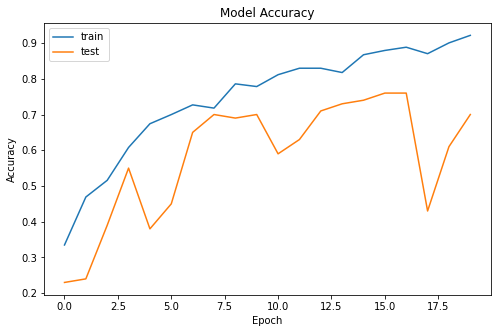

In [24]:
# Plot the model accuracy
plot_accuracy(model_cnn3d_v2.history)

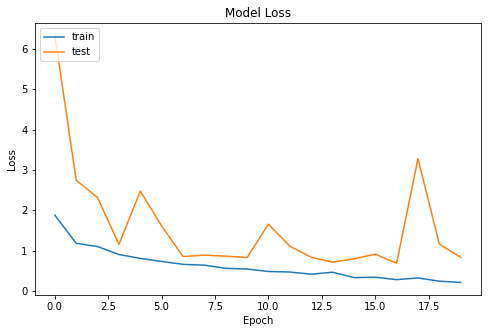

In [25]:
# Plot the model loss
plot_loss(model_cnn3d_v2.history)

## Buidl CNN3D Model version 3

In [26]:
model_cnn3d_v3  = GestureNet.cnn3d_v3()

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=2)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=2)

filepath = save_model_path(model_cnn3d_v3.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3,)
model_cnn3d_v3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnn3d_v3.summary())

# filepath:  output/CNN3D/cnn3D_lstm_03_2022-11-1617_54_41.219995/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn3D_lstm_03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 128, 128, 16)  1312      
                                                                 
 batch_normalization_13 (Bat  (None, 30, 128, 128, 16)  64       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 30, 128, 128, 16)  0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 15, 64, 64, 16)   0         
 g3D)                                                            
                                          

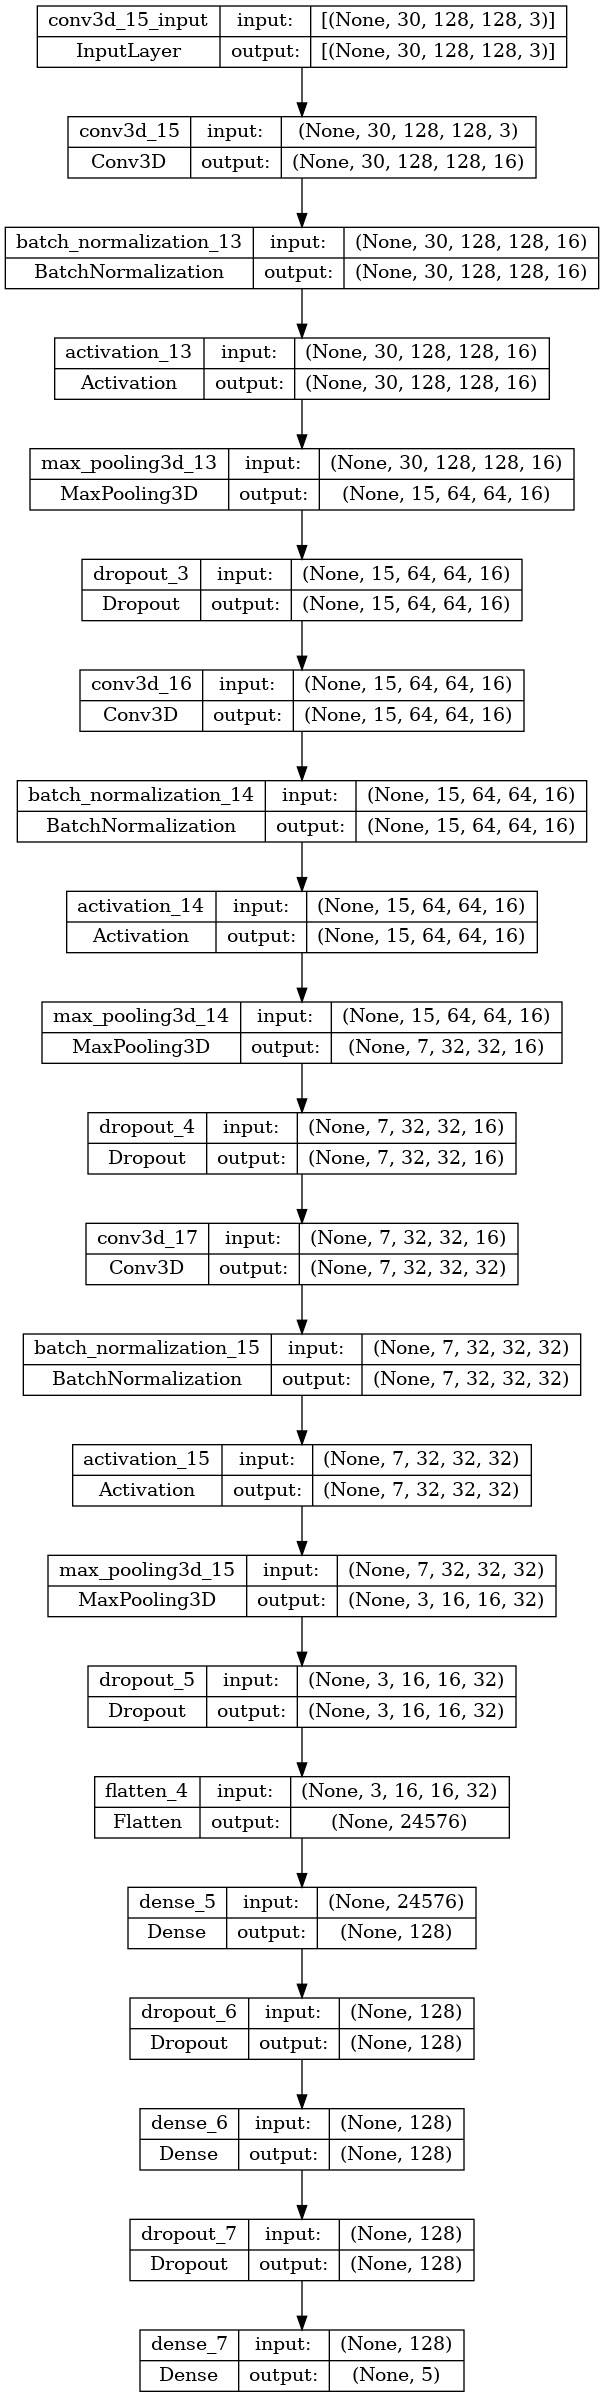

In [27]:
# Plot a diagram of the model
tf.keras.utils.plot_model(model_cnn3d_v3, "cnn3d_03.png", show_shapes=True)

In [28]:
#Train with Epochs=20
num_epochs=20
model_cnn3d_v3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-28-e265d57849f8>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_cnn3d_v3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 2
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 7.5053 - categorical_accuracy: 0.2459 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 2

Epoch 1: val_loss improved from inf to 2.73394, saving model to output/CNN3D/cnn3D_lstm_03_2022-11-1617_54_41.219995/model-00001-7.50526-0.24585-2.73394-0.17000.h5
42/42 [==============================] - 83s 2s/step - loss: 7.5053 - categorical_accuracy: 0.2459 - val_loss: 2.7339 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.6153 - categorical_accuracy: 0.1946
Epoch 2: val_loss improved from 2.73394 to 1.60301, saving model to output/CNN3D/cnn3D_lstm_03_2022-11-1617_54_41.219995/model-00002-1.61530-0.19457-1.60301-0.20000.h5
42/42 [==============================] - 80s 2s/step - loss: 1.6153 - categorical_ac

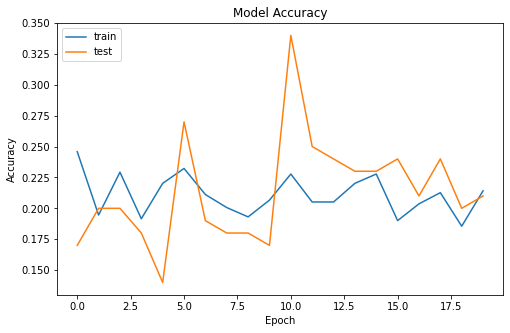

In [29]:
# Plot the model accuracy
plot_accuracy(model_cnn3d_v3.history)

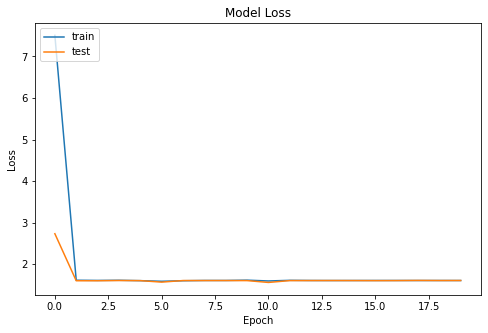

In [30]:
# Plot the model loss
plot_loss(model_cnn3d_v3.history)